# Debug Bert notebook
- [x] trivial case, with predicting shifted tokens, instead of mlm.
- [x] trivial case, of classifying presence of marker token, at a random position.
- [ ] Normalize frequency of labels across training and test samples

In [1]:
%load_ext autoreload
%autoreload 2

import tokentango

TokenTango


In [2]:
import torch
from torch.optim import Adam, AdamW
from torch import nn, functional as F
from plotly import express as px
import plotly.graph_objects as go
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from matplotlib import pyplot as plt
import itertools
import math
import datetime as dt

In [3]:
device = torch.device("mps")

```py
# 1. Embeddings padding_idx = 0, might conflict with cls, or other tokens? (model.py)
# 2. xs, masks and cls classes are all made with seperate calls to train_test_split (in bert_from_scratch.py)
#    so maybe the cls' dont match the text
num_samples = 2000

xs = torch.randint(low=1, high=10, size=(num_samples,5), dtype=torch.int32)
xs = torch.cat([torch.zeros(num_samples, 1, dtype=torch.int), xs], dim=1).to(device)

ys = xs.clone()
cls_label = [float(any(n == 1 for n in xs[i,:])) for i in range(num_samples)]

split_at = int(0.2 * num_samples)

train_x = xs[:split_at, :]
train_y = ys[:split_at, :]
train_cls = cls_label[:split_at]

test_x = xs[split_at:, :]
test_y = ys[split_at:, :]
test_cls = cls_label[split_at:]
```

In [4]:
#train_x = tokentango.fake_news.train_mlm
#train_y = tokentango.fake_news.train_x
#train_cls = tokentango.fake_news.train_y
train_x, train_y, train_cls, test_x, test_y, test_cls = tokentango.fake_news.load_data(1)

/Users/unic0rn9k/Projects/tokentango/src/tokentango/fake_news.py:15: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  large_set = pd.read_csv("995,000_rows.csv").sample(frac=frac).reset_index(drop=True)





new_labels
reliable    413063
fake        207773
Name: count, dtype: int64


/Users/unic0rn9k/Projects/tokentango/src/tokentango/fake_news.py:63: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  large_set = large_set.groupby('new_labels').apply(lambda x: x.sample(min_count, random_state=42)).sample(frac=1).reset_index(drop=True)


0.5


In [5]:
train_x = train_x.to(device)
train_y = train_y.to(device)
train_cls = train_cls.to(device)

test_x = torch.tensor(test_x).to(device)
test_y = torch.tensor(test_y).to(device)
test_cls = torch.tensor(test_cls).to(device)

/var/folders/23/q17p672911s81w1gp_wxdn3w0000gn/T/ipykernel_38407/1743132160.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_y = torch.tensor(test_y).to(device)
/var/folders/23/q17p672911s81w1gp_wxdn3w0000gn/T/ipykernel_38407/1743132160.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_cls = torch.tensor(test_cls).to(device)


In [6]:
model = tokentango.BertClassifier(300, 40000, device).to(device)

In [7]:
%%time

# 1. embedding padding_idx (from model.py) should probably be set to pad_token_id (from fake_news.py)
# 3. Maybe change named_parameters to parameters? (also in bert_from_scratch.py)
#optimizer = AdamW(model.parameters(), lr = 1e-4, eps = 1e-8)

cls_losses, mlm_losses = tokentango.train.train(model, train_x, train_y, train_cls, device)

eta: 1083112 days, 18:30:34.680000 | loss: 1.0374
eta: 1 day, 22:18:17.314504 | loss: 0.3284
eta: 2 days, 0:28:29.168214 | loss: 0.2867
eta: 1 day, 17:22:18.749474 | loss: 0.2734
eta: 1 day, 13:42:53.216709 | loss: 0.2663
eta: 1 day, 12:00:07.079442 | loss: 0.2661
eta: 1 day, 10:34:03.812317 | loss: 0.2648
eta: 1 day, 9:00:07.092064 | loss: 0.2589
eta: 1 day, 7:41:57.174947 | loss: 0.2550
eta: 1 day, 6:31:38.847281 | loss: 0.2502
eta: 1 day, 5:10:21.721517 | loss: 0.2441
eta: 1 day, 4:00:11.522128 | loss: 0.2389
eta: 1 day, 3:07:07.012141 | loss: 0.2343
eta: 117764334 days, 21:57:02.760000 | loss: 0.2295
eta: 15 days, 10:19:51.388258 | loss: 0.2259
eta: 8 days, 2:17:48.157336 | loss: 0.2219
eta: 5 days, 14:44:43.357490 | loss: 0.2182
eta: 4 days, 9:47:14.998217 | loss: 0.2153
eta: 3 days, 16:35:59.511770 | loss: 0.2122
eta: 3 days, 5:09:16.761176 | loss: 0.2103
eta: 2 days, 20:50:55.196168 | loss: 0.2069
eta: 2 days, 14:30:26.646389 | loss: 0.2044
eta: 2 days, 9:49:43.333405 | loss: 0.

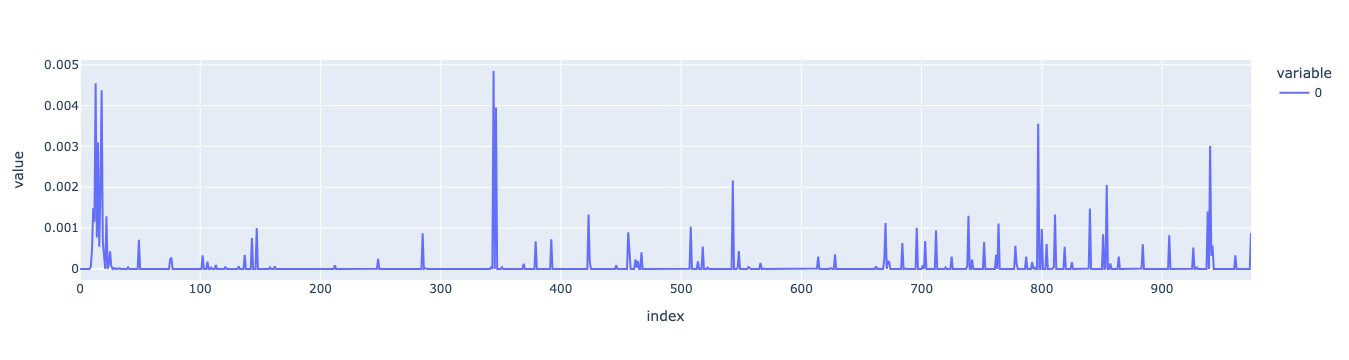

In [8]:
px.line(mlm_losses)

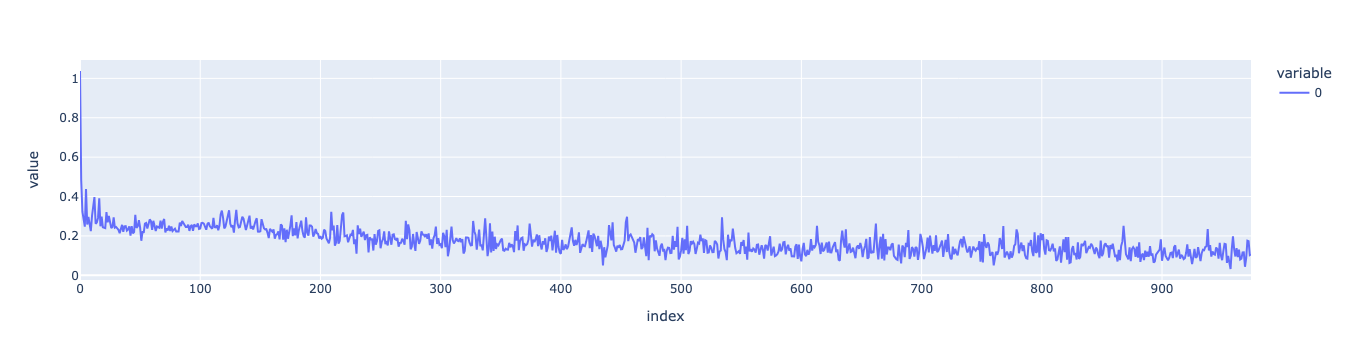

In [9]:
px.line(cls_losses)

In [10]:
outputs = []
num_samples = len(test_cls)

model.eval()
with torch.no_grad():
    for idx in range(0, num_samples):
        x = train_x[idx:idx+1,:]
        hidden = model.hidden(x)
        output = model.classifier(model.preclassifier(hidden[:,0]).relu())
        outputs.append(output)

outputs = torch.cat(outputs)

predicted_values = torch.round(outputs)
predicted_values = predicted_values.cpu().view(-1).numpy()
true_values = test_cls.cpu().numpy()
label_values = ["reliabel", "fake"]

test_accuracy = np.sum(predicted_values == true_values) / len(true_values)
print ("Test Accuracy:", test_accuracy)

print(classification_report(true_values, predicted_values, target_names=[str(l) for l in label_values]))

Test Accuracy: 0.499614968114547
              precision    recall  f1-score   support

    reliabel       0.50      0.94      0.65     41652
        fake       0.49      0.05      0.10     41458

    accuracy                           0.50     83110
   macro avg       0.49      0.50      0.38     83110
weighted avg       0.49      0.50      0.38     83110



Normalized confusion matrix
[[0.94 0.06]
 [0.95 0.05]]


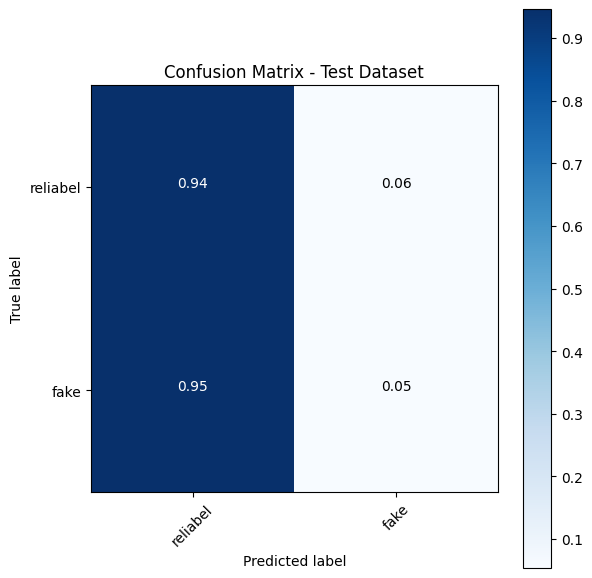

In [11]:
get_ipython().run_line_magic('matplotlib', 'inline')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# In[32]:


cm_test = confusion_matrix(true_values, predicted_values)

np.set_printoptions(precision=2)

#plt.figure(figsize=(6,6))
#plot_confusion_matrix(cm_test, classes=label_values, title='Confusion Matrix - Test Dataset')
plt.figure(figsize=(6,6))
plot_confusion_matrix(cm_test, classes=label_values, title='Confusion Matrix - Test Dataset', normalize=True)

In [12]:
print(sum(n == 1 for n in predicted_values))
print(sum(n == 0 for n in predicted_values))

4581
78529


In [13]:
positional_encoding = torch.zeros([300, 512])#, requires_grad=True)
position = torch.arange(0, 300).unsqueeze(1).float()
div_term = torch.exp(torch.arange(0, 512, 2).float() * -(math.log(10000.0) / 512))
positional_encoding[:, 0::2] = torch.sin(position * div_term)
positional_encoding[:, 1::2] = torch.cos(position * div_term)

pos_encoding_np = positional_encoding.detach().cpu().numpy()

fig = go.Figure(data=go.Heatmap(
    z=pos_encoding_np,
    colorscale='Viridis',
    showscale=True
))

fig.update_layout(
    title='Positional Encoding Heatmap',
    xaxis_title='embedding index',
    yaxis_title='sequence index'
)

fig.show()

In [14]:
np.std(outputs.detach().cpu().flatten().numpy())

np.float32(0.17304268)

In [15]:
print(sum(n == 1 for n in train_cls))
print(sum(n == 0 for n in train_cls))
print(sum(n == 1 for n in test_cls))
print(sum(n == 0 for n in test_cls))

tensor(166315, device='mps:0')
tensor(166121, device='mps:0')
tensor(41458, device='mps:0')
tensor(41652, device='mps:0')
